In [2]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline
import pandas as pd
from mpl_toolkits import mplot3d
from matplotlib import cm
import time
from scipy import sparse
from scipy.stats import norm as nm
from scipy.sparse.linalg import spsolve
from scipy.linalg import norm
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [ ]:
def U_true(a, b, u_a, u_b, f, m):
    """Compute the solution to the given linear system"""
    x_bc = numpy.linspace(a, b, m + 2)
    x = x_bc[1:-1]
    delta_x = (b - a) / (m + 1)
    
    # Construct matrix A
    A = numpy.zeros((m, m))
    diagonal = numpy.ones(m) / delta_x**2
    A += np.diag(diagonal * -2.0, 0)
    A += np.diag(diagonal[:-1], 1)
    A += np.diag(diagonal[:-1], -1)

    # Construct RHS
    b = f(x)
    b[0] -= u_a / delta_x**2
    b[-1] -= u_b / delta_x**2

    # Solve system
    U = np.empty(m + 2)
    U[0] = u_a
    U[-1] = u_b
    U[1:-1] = np.linalg.solve(A, b)
    
    return U

In [ ]:
# CALL OPTION


# choose option parameters
K = 50
r = 0.04
D = 0.12
sigma = 0.4

# choose our domain(-L, L)
L = 2

# Spatial discretization
m = 100
x = np.linspace(-L, L, m)
delta_x = x[1]-x[0]

# Time discretization
N = 101
tau = np.linspace(0.0, 1, N)
delta_tau = tau[1] - tau[0]

# construction needed for the transformation of the equation
alpha = (r-D)/(sigma**2) - 0.5
beta = (r+D)/2 + (sigma**2)/8 + ((r-D)**2)/(2*sigma**2)

# insert the boundary conditions and the initial condition into the matrix

# boundary conditions for the transformed equation
g_0 = lambda tau: 0.   #V(t, S_min)  x = x_min
g_L = lambda tau: K*np.exp(alpha*L + beta*tau)*(np.exp(L-D*tau)-np.exp(-r*tau))  #V(t, S_max)  x = x_max

# initial condition
u0 = lambda x: K*np.exp(alpha*x)*np.maximum(0,np.exp(x)-1) # tau = 0

# solution array
U = np.zeros((m, N))
U[:,0] = u0(x)
U[0,:] = g_0(tau)
U[-1,:] = g_L(tau)

# define the variables
a = -0.5*(sigma**2)*delta_tau/(delta_x**2)
b = 1-2*a

# other parameters
omega = 2.0 / (1.0 + np.sin(np.pi * delta_x))
eps = 0


In [ ]:
iterations_SOR = int(2.0 * np.log(delta_x) / np.log(1.0 - 2.0 * np.pi * delta_x)) * 2

def SOR(a,b,U1,eps,omega,iterations_SOR):
    
    def SOR_inner(a,b,rhs,v0,eps,omega,iterations_SOR):
        le = len(v0)
        v = v0
        for k in range(iterations_SOR):
            
            
#             for i in range(1, le-1):
#                 U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
#                 U[i] += omega * (U_gs - U[i])
            
            U_gs = (rhs[0]-a*v[1])/b
            v[0] += omega*(U_gs-v[0])

            for i in range(1,le-1):
                
                U_gs = (rhs[i]-a*(v[i-1]+v[i+1]))/b
                v[i] += omega*(U_gs-v[i])

            U_gs = (rhs[-1] - a*v[-2])/b
            v[-1] += omega*(U_gs-v[-1]) 
            
        return v
    
    for i in range(1,N):
        
        # compute the first time level(the values at time k)

        rhs = U1[1:-1,i-1]
        rhs[0] = rhs[0] - a*g_0(delta_tau)
        rhs[-1] = rhs[-1] - a*g_L(delta_tau)

        v0 = U1[1:-1,i]
        
        v1 = SOR_inner(a,b,rhs,v0,eps,omega,iterations_SOR)

        U1[1:-1,i] = v1
        if i == 0:
            print(U1[1:-1,i])
            print(U1)

    return U1


In [ ]:
# solution array
U = np.zeros((m, N))
U[:,0] = u0(x)
U[0,:] = g_0(tau)
U[-1,:] = g_L(tau)


U_final = SOR(a,b,U,eps,omega,iterations_SOR)
print(U_final[1:-1,1])
plt.scatter(K*np.exp(x), U_final[:,0], c ="blue")

In [ ]:
iterations_SOR = int(2.0 * np.log(delta_x) / np.log(1.0 - 2.0 * np.pi * delta_x)) * 2

def SOR(a,b,U,eps,omega,iterations_SOR):
    
    def SOR_inner(a,b,rhs,v0,eps,omega,iterations_SOR):
        le = len(v0)
        v = v0
        for k in range(iterations_SOR):
            
            v[0] = (rhs[0] - a*v[1])/b
            for i in range(1, le-1):
                v[i] = rhs[i]-a*(v[i-1]+v[i+1])/b
            
            v[-1] = (rhs[-1] - a*v[-2])/b
            
        return v
    
    for i in range(1,N):
        
        # compute the first time level(the values at time k)

        rhs = U[1:-1,i-1]
        rhs[0] = rhs[0] - a*g_0(delta_tau)
        rhs[-1] = rhs[-1] - a*g_L(delta_tau)

        v0 = U[1:-1,i]

        U[1:-1,i] = SOR_inner(a,b,rhs,v0,eps,omega,iterations_SOR)


    return U


In [ ]:
# solution array
U = np.zeros((m, N))
U[:,0] = u0(x)
U[0,:] = g_0(tau)
U[-1,:] = g_L(tau)

U_final = SOR(a,b,U,eps,omega,iterations_SOR)
plt.scatter(K*np.exp(x), U_final[:,0], c ="blue")

In [ ]:
x, tau = np.meshgrid(x, tau)

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(tau, x, U);

In [ ]:
step_size_SOR = np.zeros(iterations_SOR)
convergence_SOR = np.zeros((iterations_SOR, 2))
for k in range(iterations_SOR):
#     U_old = U.copy()
#     for t in range(1,n+1):
        
    for i in range(1, m - 1):
        U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
        U[i] += omega * (U_gs - U[i])

    step_size_SOR[k] = np.linalg.norm(U_old - U, ord=2)
    convergence_SOR[k, 0] = np.linalg.norm(U_system - U, ord=2)
    convergence_SOR[k, 1] = np.linalg.norm(u_true(x_bc) - U, ord=2)
    

In [3]:
r = 0.1
sigma = 0.2
S_0 = 100
X_0 = np.log(50)
K = 100
T_end = 1

In [4]:
N_space = 3000   # M space steps
N_time = 2000    # N time steps   

S_max = 3*float(K)                
S_min = float(K)/3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

In [5]:
x, dx = np.linspace(x_min, x_max, N_space, retstep=True)   # space discretization
T, dt = np.linspace(0, T_end, N_time, retstep=True)       # time discretization
payoff = np.maximum(np.exp(x)-K,0)          # Call payoff

In [6]:

V = np.zeros((N_space,N_time))       # grid initialization
rhs = np.zeros(N_space-2)        # vector to be used for the boundary terms   


# initial value and boundary conditions
V[:,-1] = payoff                  
V[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )
V[0,:] = 0                         

In [7]:
# define the variables which apppear in the tri-diagonal matrix D and construct matrix D

a = ( (dt/2) * ( (r-0.5*(sigma**2))/dx - (sigma**2)/(dx**2) ) )
b = ( 1 + dt * ( (sigma**2)/(dx**2) + r ) )
c = (-(dt/2) * ( (r-0.5*(sigma**2))/dx + (sigma**2)/(dx**2) ) )

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(N_space-2, N_space-2)).tocsc()

In [8]:
# Backward iteration
for i in range(N_time-2,-1,-1):
    rhs[0] = a * V[0,i]
    rhs[-1] = c * V[-1,i]
    V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - rhs) ) 

In [ ]:
# Forward iteration
for i in range(0,N_time-1,1):
    rhs[0] = a * V[0,i+1]
    rhs[-1] = c * V[-1,i+1]
    V[1:-1,i+1] = spsolve( D, (V[1:-1,i] - rhs) ) 

In [ ]:
# SOR iteration
for i in range(1,N_time-2,1):
    
    
    rhs[0] = a * V[0,i]
    rhs[-1] = c * V[-1,i]
    
    U_gs = 
    v[i] += omega*((rhs[i]-a*(v[i-1]+v[i+1]))/b-v[i])
    
    v_old = V[0,i]
    v_gs = rh
    
    V[1:-1,i] = spsolve( D, (V[1:-1,i-1] - rhs) ) 

In [9]:
# finds the option at S0
oPrice = np.interp(X_0, x, V[:,0])
print(oPrice)

0.005834515735767997


In [ ]:
S = np.exp(x)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,1999], color='red',label="BS curve")
ax1.set_xlim(60,170); ax1.set_ylim(0,50)
ax1.set_xlabel("S"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

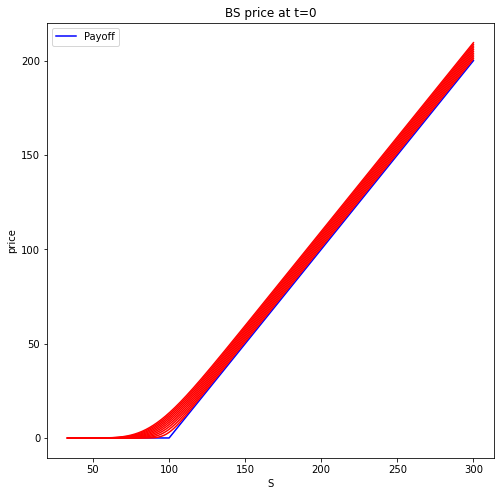

<Figure size 576x576 with 0 Axes>

In [28]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

S = np.exp(x)
plt.figure(figsize=(8,8))
plt.ion()
plt.plot(S, payoff, color='blue',label="Payoff")
plt.xlabel("S")
plt.ylabel("price")
plt.legend(loc='best')
plt.title("BS price at t=0")
for i in range(int(N_time/200)):
    
    plt.plot(S, V[:,i*200], color='red',label="BS curve")
#     plt.pause(1)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    plt.draw()
    time.sleep(1)
plt.xlim(60,170)
plt.ylim(0,50)
plt.clf()


In [ ]:
# Code for exact solution


In [3]:
# ---------------------------- Parameter Setup ----------------------------
r = 0.1
sigma = 0.2
S_0 = 100
X_0 = np.log(50)
K = 100
T_end = 1

# Space/Time steps

N_space = 3000   
N_time = 2000     

S_max = 3*float(K)                
S_min = float(K)/3

x_max = np.log(S_max)  
x_min = np.log(S_min) 

# Space/Time Discretization

x, dx = np.linspace(x_min, x_max, N_space, retstep=True)   
T, dt = np.linspace(0, T_end, N_time, retstep=True)  

# Call Payoff
payoff = np.maximum(np.exp(x)-K,0)    

# Grid N_space and N_time
V_GS = np.zeros((N_space,N_time)) 
V_SOR = np.zeros((N_space,N_time)) 

# Boundary
rhs = np.zeros(N_space-2)          


# Initial Value and Boundary Conditions of Gauss Seidel
V_GS[:,-1] = payoff                  
V_GS[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )
V_GS[0,:] = 0    

# Initial Value and Boundary Conditions of SOR
V_SOR[:,-1] = payoff                  
V_SOR[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )
V_SOR[0,:] = 0  

# define the variables which apppear in the tri-diagonal matrix D and construct matrix D

a = ( (dt/2) * ( (r-0.5*(sigma**2))/dx - (sigma**2)/(dx**2) ) )
b = ( 1 + dt * ( (sigma**2)/(dx**2) + r ) )
c = (-(dt/2) * ( (r-0.5*(sigma**2))/dx + (sigma**2)/(dx**2) ) )

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(N_space-2, N_space-2)).tocsc()

In [5]:
# ---------------------------- Numerical Method (SOR) Setup ----------------------------
# SOR

def SOR(a, b, c, d, w=1, eps=1e-10, itera = 100):

    N = len(d)

    # Initial Guess
    x_old = np.ones(N)  

    # New Solution             
    x_new = np.ones(N)               
    
    for k in range(1,itera+1):

        for i in range(N):

            if i == 0 :
                sor = c * x_new[1]
            elif (i==N-1):
                sor = a * x_new[N-2]
            else:
                sor = a * x_new[i-1] + c * x_new[i+1]

            x_new[i] = (1-w)*x_new[i] + (w/b) * (d[i] - sor)  

        if norm(x_new - x_old) < eps:
            return x_new
        
        x_old = x_new.copy()

        if k == itera:
            print("Fail to converge in {} iterations".format(k))
            return x_new


for i in range(N_time-2,-1,-1): 
    rhs[0] = a * V_SOR[0,i]
    rhs[-1] = c * V_SOR[-1,i]
    V_SOR[1:-1,i] =  SOR(a, b, c, (V_SOR[1:-1,i+1] - rhs), w=1.68, eps=1e-10, itera=600 )

1998
1997
1996
1995
1994
1993
1992
1991
1990
1989
1988
1987
1986
1985
1984
1983
1982
1981
1980
1979
1978
1977
1976
1975
1974
1973
1972
1971
1970
1969
1968
1967
1966
1965
1964
1963
1962
1961
1960
1959
1958
1957
1956
1955
1954
1953
1952
1951
1950
1949
1948
1947
1946
1945
1944
1943
1942
1941
1940
1939
1938
1937
1936
1935
1934
1933
1932
1931
1930
1929
1928
1927
1926
1925
1924
1923
1922
1921
1920
1919
1918
1917
1916
1915
1914
1913
1912
1911
1910
1909
1908
1907
1906
1905
1904
1903
1902
1901
1900
1899
1898
1897
1896
1895
1894
1893
1892
1891
1890
1889
1888
1887
1886
1885
1884
1883
1882
1881
1880
1879
1878
1877
1876
1875
1874
1873
1872
1871
1870
1869
1868
1867
1866
1865
1864
1863
1862
1861
1860
1859
1858
1857
1856
1855
1854
1853
1852
1851
1850
1849
1848
1847
1846
1845
1844
1843
1842
1841
1840
1839
1838
1837
1836
1835
1834
1833
1832
1831
1830
1829
1828
1827
1826
1825
1824
1823
1822
1821
1820
1819
1818
1817
1816
1815
1814
1813
1812
1811
1810
1809
1808
1807
1806
1805
1804
1803
1802
1801
1800
1799


KeyboardInterrupt: 